[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/DLImaging/blob/master/notebooks/08-Autoencoder_drawings.ipynb)

# Autoencoder

In the previous chapters, we used neural networks mainly to classify images, and we did that by *compressing* or *encoding* the information e.g. by taking in the ```28*28=784``` pixels of an image and outputting 100 values through a linear layer. Here we will see that instead of using that compression for classification, we can *reverse* it by adding a *decompression* or decoding block. Such a network with an encoder and a decoder is called an **autoencoder**. Such architectures are found in many places in image processing, in particular for denoising, segmentation and generation.

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

## Dataset

In this chapter, we use again our quickdraw dataset. Le't create again our standard dataloader:

In [6]:
class Drawings(Dataset):
    """Dataset class for quickdraw. Inputs are arrays of linearized 
    images and arrays of labels."""
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        x = np.reshape(x, (28,28))
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.targets)

In [8]:
transformations = transforms.Compose([
    transforms.ToTensor(),
])

num_data = 10000
batch_size = 32

folders = list(datapath.joinpath('data/quickdraw').glob('*npy'))
label_dict = {i:f.name.split('_')[-1][:-4] for i, f in enumerate(folders)}

data = np.concatenate([np.load(f)[0:num_data] for f in folders]) #check everything works with tiny set
labels = np.concatenate([[ind for i in range(num_data)] for ind, f in enumerate(folders)]) #check everything works with tiny set

rng = np.random.default_rng()
indices = rng.choice(len(data), size=len(data), replace=False)

train_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[0:int(0.8*len(data))], batch_size=batch_size)
valid_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[int(0.8*len(data))::], batch_size=batch_size)

## Linear auto-encoder

First we adapt some one of the first networks we used and turn our linear classifier into a linear auto-encoder. We use here a very simple auto-encoder: first a fully connected layer that turns the input vector (flattened image) of size ```width x height``` into a vector of size ```encoder_size```. Then this vector is re-expanded to the original size again via a fully connected layer. Note that the goal of the decoder part is to re-create the original image. So we don't use a typical classification loss as before (cross-entropy), but a loss that quantifies the error between original and auto-encoded image, i.e. the distance between pixel values. Here we do this with the Mean Squared Error.

In [9]:
class Linautoencoder(pl.LightningModule):
    def __init__(self, encoder_size):
        super(Linautoencoder, self).__init__()
        
        self.lin1 = nn.Linear(28*28, encoder_size)
        self.lin2 = nn.Linear(encoder_size, 28*28)
        self.loss = nn.MSELoss()

    def forward(self, x):
        
        x = x.view(-1,784)
        x = F.relu(self.lin1(x))
        output = torch.sigmoid(self.lin2(x))
    
        return output
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, x.view(-1,784))
        
        self.log('train/loss', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, x.view(-1,784))

        self.log('valid/loss', loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    

As an extreme example, we will compress the image to a vector of size 4:

In [10]:
mynet = Linautoencoder(encoder_size=4)

In [11]:
im, lab = next(iter(train_loader))

In [12]:
output = mynet(im)

In [13]:
output.shape

torch.Size([32, 784])

In [14]:
trainer = pl.Trainer(max_epochs=10, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [15]:
trainer.fit(mynet, train_dataloaders=train_loader, val_dataloaders=valid_loader)


  | Name | Type    | Params
---------------------------------
0 | lin1 | Linear  | 3.1 K 
1 | lin2 | Linear  | 3.9 K 
2 | loss | MSELoss | 0     
---------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Now we can check what happens when we compress an image to a vector of 4 values and re-expand it. We just use the validation data for this: 

In [16]:
im_valid, lab_valid = next(iter(valid_loader))

In [17]:
pred = mynet(im_valid)

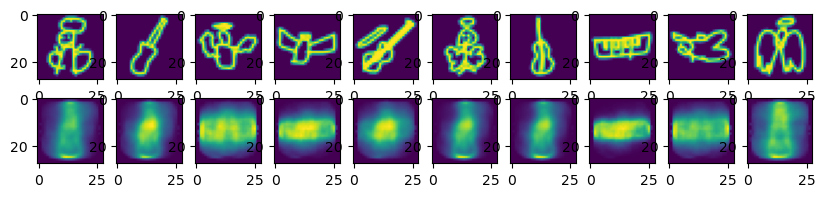

In [18]:
fig, ax = plt.subplots(2,10, figsize=(10,2))
for ind in range(10):
    ax[0,ind].imshow(torch.reshape(im_valid[ind],(28,28)))
    ax[1,ind].imshow(torch.reshape(pred.detach()[ind],(28,28)))


Obviously a lot of information has been lost in the compression. However the outputs are not entirely random and capture some of the image features. Let's see now if we can improve the result by using convolutions.

## Convolutional auto-encoder

Convolutions are of course much better at recovering spatial information and make for much better autoencoders. We use here a simple architecture that will serve later as basis for a segmentation network. It is composed of a series of:
- encoder: convolutions and max-pooling
- decoder: transpose convolutions

It would be useful to have access to the encoder and decoder separately. There are multiple ways to do this. Here we simply create two PyTorch modules and then assemble them into a Lightning module:

In [20]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, stride=2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, stride = 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, stride = 2, kernel_size=3, padding=0)
        self.fc = nn.Linear(3*3*128, latent_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.fc(x.view(-1, 3*3*128))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(latent_size, 3*3*128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,  padding=1, output_padding=1)
        
    def forward(self, x):
        
        x = self.fc(x)
        x = x.view(-1,128,3,3)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        
        return x

In [21]:
class Convautoencoder(pl.LightningModule):
    def __init__(self, latent_size):
        super(Convautoencoder, self).__init__()
        
        self.encoder = Encoder(latent_size=latent_size)
        self.decoder = Decoder(latent_size=latent_size)
        
        self.loss = nn.MSELoss()

    def forward(self, x):
        
        x = self.encoder(x)
        output = self.decoder(x)
        
        return output
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output.view(-1,784), x.view(-1,784))
        
        self.log('train/loss', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output.view(-1,784), x.view(-1,784))

        self.log('valid/loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


Now we instantiate our model and train it. We train it again using a latent space (the encoding vector) of size 4. Before anything we verify that all parts of our autoencoder give the correct outputs and check the current results of the untrained model:

In [36]:
del mynet
mynet = Convautoencoder(latent_size=4)

In [37]:
im, lab = next(iter(train_loader))

In [38]:
out_en = mynet.encoder(im)

In [39]:
out_en.shape

torch.Size([32, 4])

In [40]:
out_de = mynet.decoder(out_en)

In [41]:
out_de.shape

torch.Size([32, 1, 28, 28])

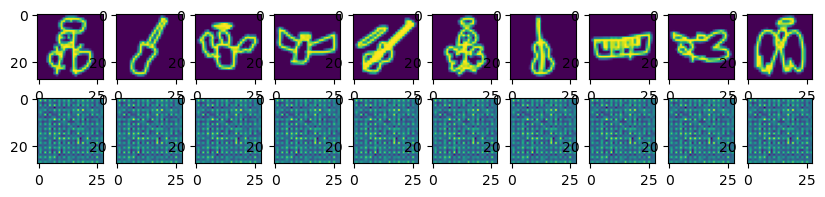

In [42]:
im_valid, lab_valid = next(iter(valid_loader))
pred = mynet(im_valid)

fig, ax = plt.subplots(2,10, figsize=(10,2))
for ind in range(10):
    ax[0,ind].imshow(torch.reshape(im_valid[ind],(28,28)))
    ax[1,ind].imshow(torch.reshape(pred.detach()[ind],(28,28)))

We see that we get completely random outputs as expected. Let's train the network!

In [43]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="ae")
trainer = pl.Trainer(logger=logger, max_epochs=2)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [44]:
trainer.fit(mynet, train_dataloaders=train_loader, val_dataloaders=valid_loader)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 97.3 K
1 | decoder | Decoder | 98.3 K
2 | loss    | MSELoss | 0     
------------------------------------
195 K     Trainable params
0         Non-trainable params
195 K     Total params
0.782     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Let's verify the quality of our reconstructions:

In [45]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19759), started 0:04:48 ago. (Use '!kill 19759' to kill it.)

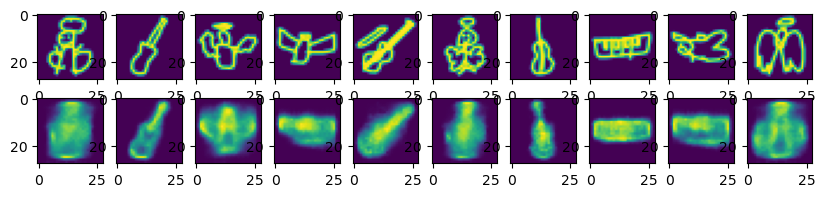

In [46]:
im_valid, lab_valid = next(iter(valid_loader))
pred = mynet(im_valid)

fig, ax = plt.subplots(2,10, figsize=(10,2))
for ind in range(10):
    ax[0,ind].imshow(torch.reshape(im_valid[ind],(28,28)))
    ax[1,ind].imshow(torch.reshape(pred.detach()[ind],(28,28)))


## How does the latent space look ?

Our network compresses the image information into a N-dimensional vector. In an extreme case we can just use a space of size 2. Then our images can be represented as points in a 2D graph, allowing us to better understand what is happending. Let's train again our network:

In [47]:
mynet = Convautoencoder(latent_size=2)

trainer = pl.Trainer(logger=logger, max_epochs=2)
trainer.fit(mynet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory tb_logs/ae/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 95.0 K
1 | decoder | Decoder | 96.0 K
2 | loss    | MSELoss | 0     
------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.764     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


We now consider all our validation examples. We re-use the random indices that we defined previously and take a 100 images:

In [48]:
test_data = data[indices[int(0.8*len(data)):int(0.8*len(data))+100]]
test_labels = labels[indices[int(0.8*len(data)):int(0.8*len(data))+100]]

In [49]:
outputs = []
labels = []
for val in valid_loader:
    outputs.append(mynet.encoder(val[0]))
    labels.append(val[1])

In [50]:
outputs = torch.cat(outputs)
labels = torch.cat(labels)

In [51]:
outputs = outputs.detach().numpy()
labels = labels.detach().numpy()

In [52]:
(labels==0).shape

(6000,)

In [53]:
outputs.shape

(6000, 2)

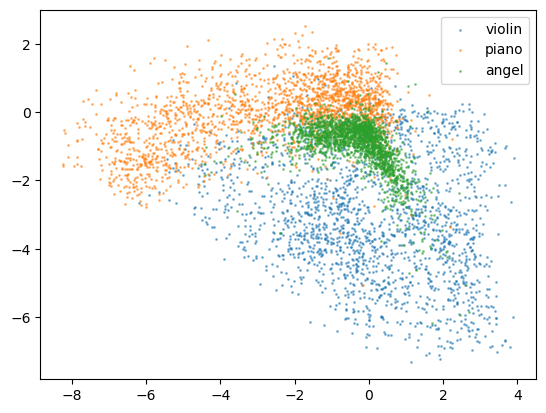

In [58]:
for i in range(3):
    plt.scatter(outputs[labels==i,0],outputs[labels==i,1],marker='o', s=1, alpha = 0.5, label=label_dict[i])
plt.legend();

We see that our categories get clustered together. However clustering is not perfect, in particular, the angel category is overlapping with the two others. Violin and piano in contrast are well separated probably because one tends to be roundish, while the other one is square.

We can now even sample from this distribution and generate new images:

In [59]:
gen_image = mynet.decoder(torch.tensor([0, -5], dtype=torch.float32).unsqueeze(0).unsqueeze(0))

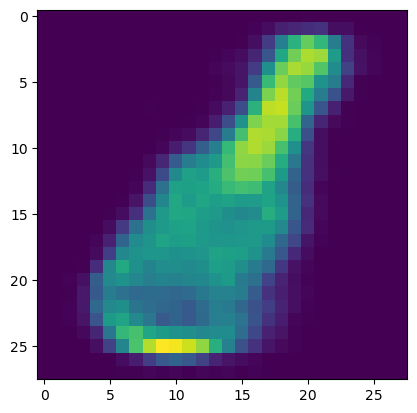

In [60]:
plt.imshow(gen_image[0,0].detach());

If we choose coordinates clearly belonging to one category we obtain images with the right shapes. In mixed regions or in non-defined regions the results are more random. We will see later that we can improve this generation of image by creating a **variational auto-encoder**.

## Denoising

Now that we have a network that can re-create an image after having compressed it, we could use it for denoising. Indeed if an image contains pixels outside of the expected range, those should disappear in the encoding stage so that the reconstructed image is cleaned-up.

Above we trained the network to reproduce the image that has passed through the network. Here we pass a *corrupted* image through the network but train it to match the *uncorrupted* version. Here we do this by artifically adding random noise to the image during training. Of course in real situation one would need to acquire images e.g. in good and bad conditions (imagine low vs. high illumination) and use those pairs for training. This is the approach used for example in the [CARE](https://www.nature.com/articles/s41592-018-0216-7) software used to restore microscopy images.

We copy here our network and add noise in the training phase:

In [67]:
class Denoiser(pl.LightningModule):
    def __init__(self, latent_size):
        super(Denoiser, self).__init__()
        
        self.encoder = Encoder(latent_size=latent_size)
        self.decoder = Decoder(latent_size=latent_size)
        
        self.loss = nn.MSELoss()

    def forward(self, x):
        
        x = self.encoder(x)
        output = self.decoder(x)
        
        return output
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        #!!!!!!!!!!!!!!!!!!!! Add noise here !!!!!!!!!!!!!!!!!!!!!!!!!
        x_noise = x + 0.2*torch.randn(x.size())
        output = self(x_noise)
        loss = self.loss(output.view(-1,784), x.view(-1,784))
        
        self.log('train/loss', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        #!!!!!!!!!!!!!!!!!!!! Add noise here !!!!!!!!!!!!!!!!!!!!!!!!!
        x_noise = x + 0.2*torch.randn(x.size())
        output = self(x_noise)
        loss = self.loss(output.view(-1,784), x.view(-1,784))

        self.log('valid/loss', loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [68]:
denois_net = Denoiser(latent_size=100)

from pytorch_lightning.loggers import TensorBoardLogger
trainer = pl.Trainer(max_epochs=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [69]:
trainer.fit(denois_net, train_dataloaders=train_loader, val_dataloaders=valid_loader)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 207 K 
1 | decoder | Decoder | 208 K 
2 | loss    | MSELoss | 0     
------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.667     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [64]:
im_valid, lab_valid = next(iter(valid_loader))
im_valid_noise = im_valid + 0.2*torch.randn(im_valid.size())

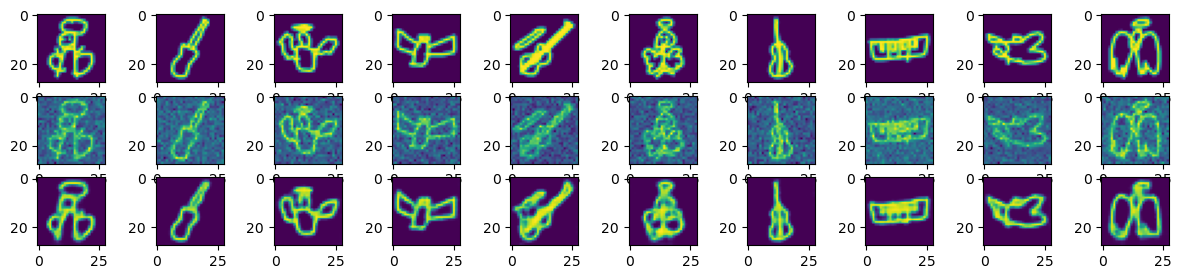

In [65]:
pred = denois_net(im_valid_noise)
fig, ax = plt.subplots(3,10, figsize=(15,3))
for ind in range(10):
    ax[0,ind].imshow(torch.reshape(im_valid[ind],(28,28)))
    ax[1,ind].imshow(torch.reshape(im_valid_noise[ind],(28,28)))
    ax[2,ind].imshow(torch.reshape(pred.detach()[ind],(28,28)))


In [66]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19759), started 3:11:48 ago. (Use '!kill 19759' to kill it.)